# Terminator

Procederé a aplicar todo lo que no aprendí este semestre según mis calificaciones 

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve,ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, log_loss
import pandas as pd
import numpy as np
from sklearn import preprocessing as ps
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.optimize import minimize
from sklearn.cluster import KMeans

In [3]:
d2=pd.read_csv("Data_set_200_280.csv")

In [4]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,5.556148e-07,4.686493e-10,0.000008
1,Healthy,6.529095e-07,2.819616e-10,0.000009
2,Healthy,6.096350e-07,2.985569e-10,0.000009
3,Healthy,5.567451e-07,2.556868e-10,0.000008
4,Healthy,5.016411e-07,3.071286e-10,0.000007
...,...,...,...,...
4914,Wheezes,1.017147e-05,1.164674e-08,0.000136
4915,Wheezes,9.649835e-06,8.796041e-09,0.000129
4916,Wheezes,1.124116e-06,7.448796e-10,0.000015
4917,Wheezes,9.903341e-07,4.516410e-10,0.000013


Inicialmente se hace un encoder para convertir las variables cualitativas en cuantitativas en este caso solo afectando la columna de estados

In [5]:
encoder = ps.LabelEncoder()
d2["Estado"]=encoder.fit_transform(d2["Estado"])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Estado     4919 non-null   int32  
 1   Sumatoria  4919 non-null   float64
 2   Mediana    4919 non-null   float64
 3   Varianza   4919 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 134.6 KB
None


En este caso Sano:1 crepitante:0 y silibante:2

## Normalización

Normalizaremos los valores de cada columna dividiéndolos por el valor máximo para tener valores entre 0 y 1 en cada columna, para ello cada vez que tengamos un Xtv entrenaremos un modelo con estos datos y Xts,Xtv se transformaran bajo dicho modelo se normalizaran los datos usando la función StandardScaler

Ahora revisemos la correlación con nuestro target de predicción que seria el estado

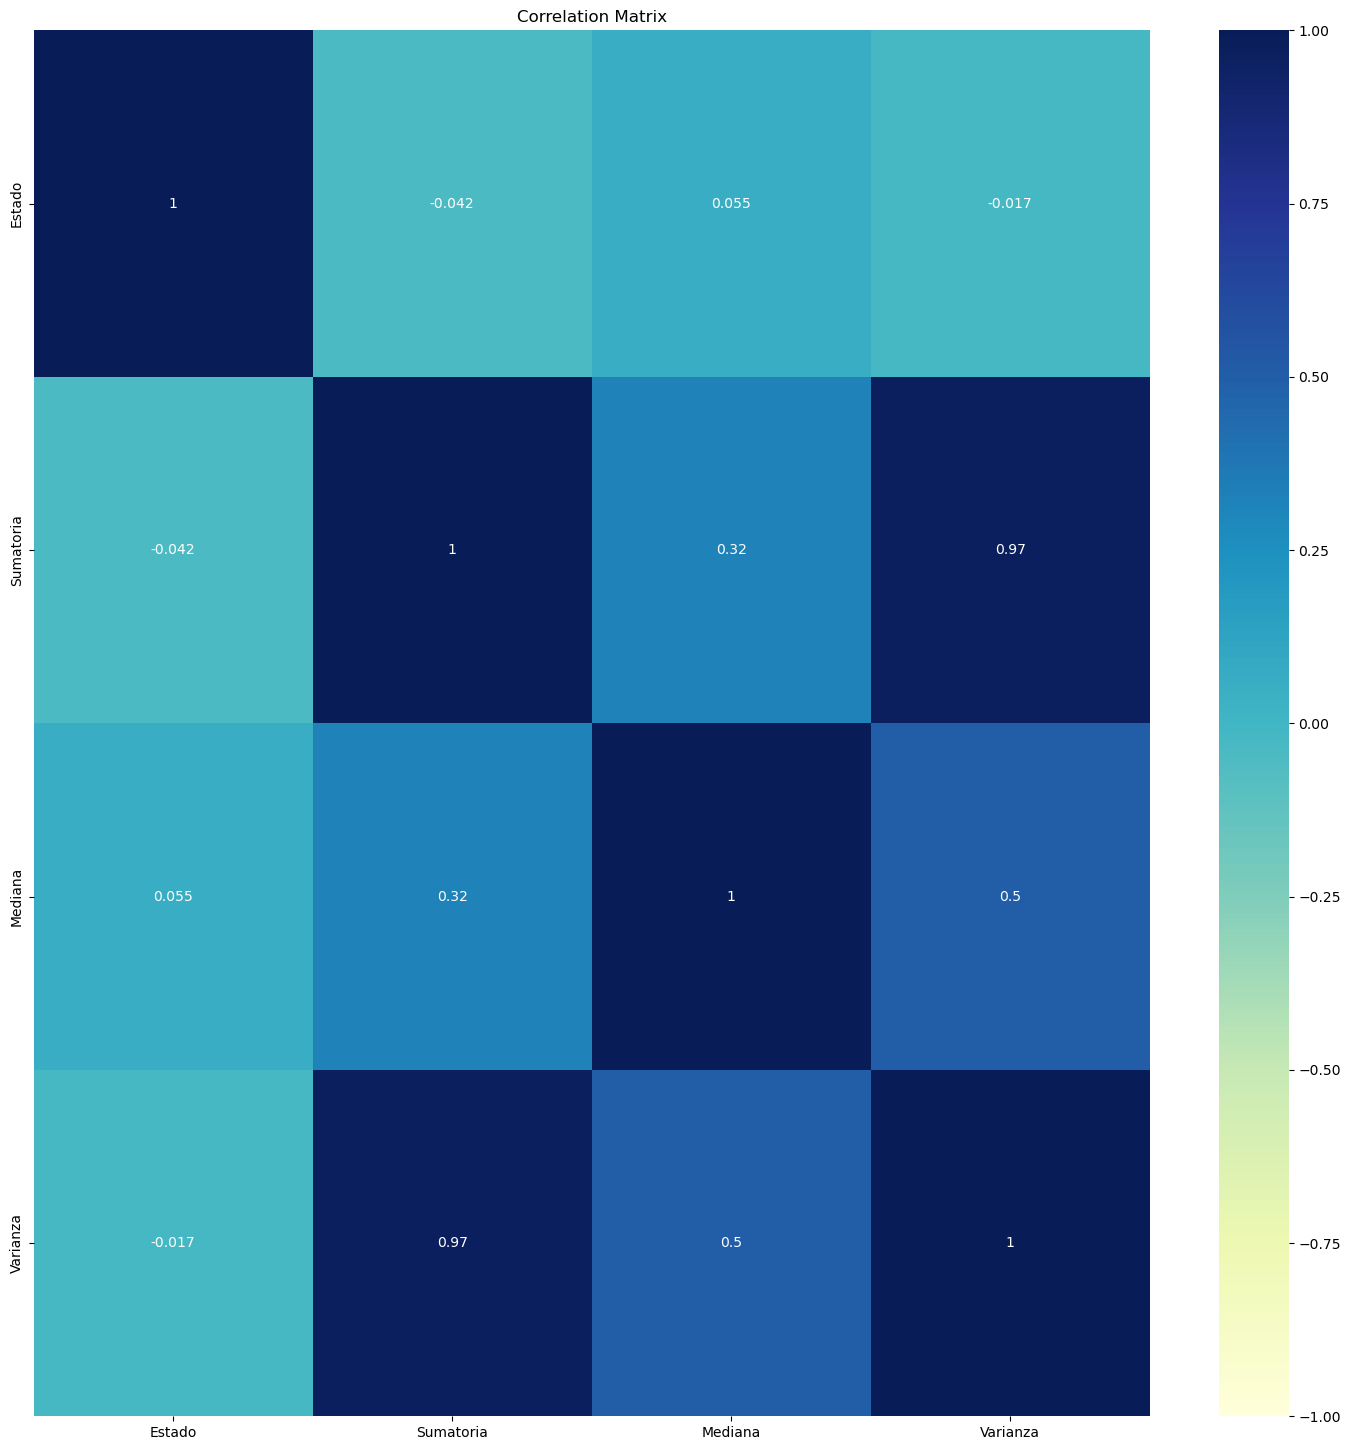

In [8]:
corr_matrix = d2.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [26]:
target_corr_df = pd.DataFrame(corr_matrix["Estado"].sort_values(ascending=False))
target_corr_df 

,Estado
Estado,1.000000
Mediana,0.054825
Varianza,-0.016609
Sumatoria,-0.042180


En este caso podemos observar que el estado va relacionado mayormente con la mediana que en el caso de la varianza o la suma, con esto en mente priorizaremos este parámetro para la generación de las redes neuronales

In [9]:
def tuple_generator(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)

In [69]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y,train_sizes= [0.3, 0.5,0.7,0.9],
                 scoring ='neg_log_loss', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Log_Loss"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

## Funciones de perdida para optimización

- En este caso en vez de usar F1 se usa el coste de log_loss o el coste de la entropía cruzada del sistema que seria la función negativa de esta, debido a que es mejor métrica para los sistemas binarios como son el caso de los primeros ejemplos

Adicionalmente vamos a ver las curvas de aprendizaje para evitar el sobre entrenamiento con los datos dados

# 1. Ciclos normales y ciclos crepitantes

## Entrenamiento

In [24]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
def metrics(a,Xtv,ytv,Xts,yts,target_names):
    a.fit(Xtv,ytv)
    predict_train = a.predict(Xtv)
    predict_test = a.predict(Xts)
    print("Train ",a.activation)
    print("------------")
    print(classification_report(ytv,predict_train))
    mc_train = confusion_matrix(ytv,predict_train)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train '+a.activation)
    print("------------")
    print("Test ",a.activation)
    print(classification_report(yts,predict_test))
    mc_train = confusion_matrix(yts,predict_test)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix test '+a.activation)

In [26]:
def tuple_generator1(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)

In [23]:
def tuple_generator(start, end):
    return list(itertools.product(range(start, end+ 1), repeat=3))

In [27]:
def me_da_pereza(i,Xtv,ytv,Xts,yts,target_names):
    for a in i:
        metrics(a,Xtv,ytv,Xts,yts,target_names)

En este caso vamos a probar con varias redes neuronales, cambiaremos la activación para cambiar la arquitectura lo mismo que el solucionador de ser necesario, esto cambiara la forma del sigmoide, en el proceso se ira permutando los valores hasta encontrar un modelo más adecuado para la predicción 

## Resultados

## Lo que si se pidió

In [70]:

d=pd.concat([d2[d2["Estado"]==0],d2[d2["Estado"]==1]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)
scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)
print (Xtv.shape, Xts.shape)

(4264, 3) (4264,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2984, 3) (1280, 3)


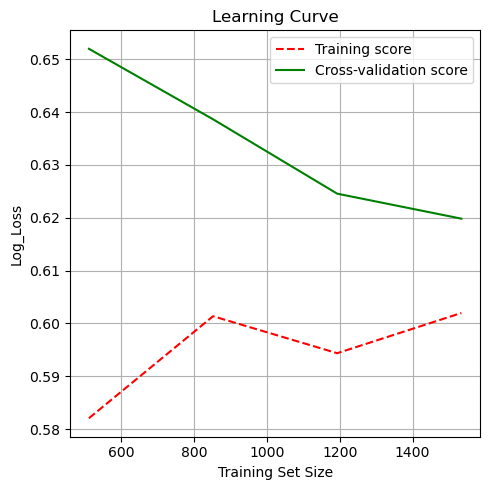

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [71]:
mlp= MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu',solver='adam', max_iter=10000)
lc_plot(mlp,Xtv,ytv)

Train  relu
------------
              precision    recall  f1-score   support

           0       0.58      0.39      0.47      1141
           1       0.69      0.82      0.75      1843

    accuracy                           0.66      2984
   macro avg       0.63      0.61      0.61      2984
weighted avg       0.65      0.66      0.64      2984

Confusion matrix, without normalization
[[ 449  692]
 [ 323 1520]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.56      0.39      0.46       490
           1       0.68      0.81      0.74       790

    accuracy                           0.65      1280
   macro avg       0.62      0.60      0.60      1280
weighted avg       0.63      0.65      0.63      1280

Confusion matrix, without normalization
[[190 300]
 [151 639]]
Train  identity
------------
              precision    recall  f1-score   support

           0       0.60      0.07      0.12      1141
           1       0.63      

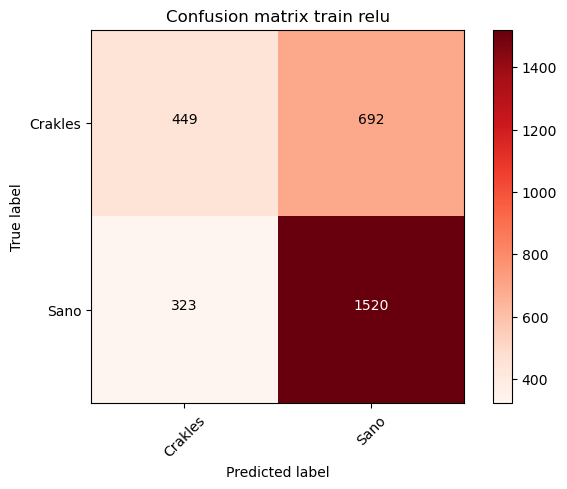

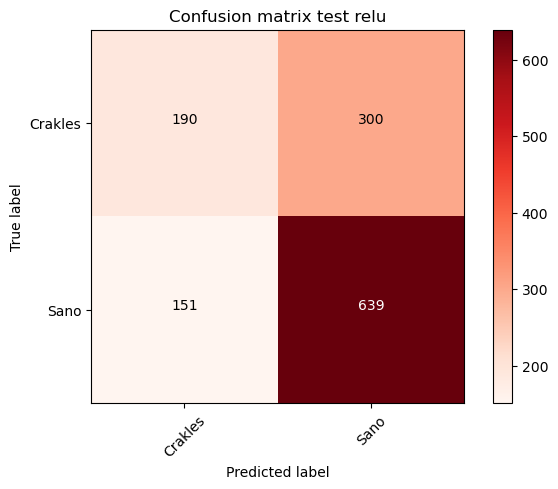

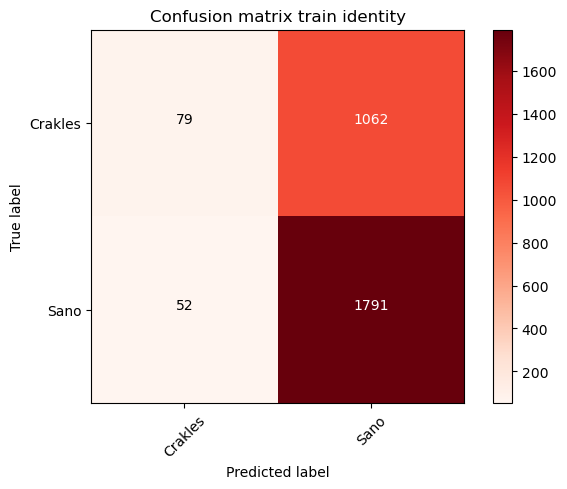

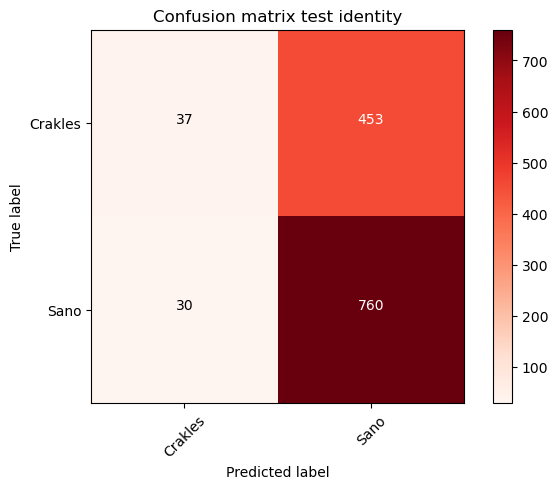

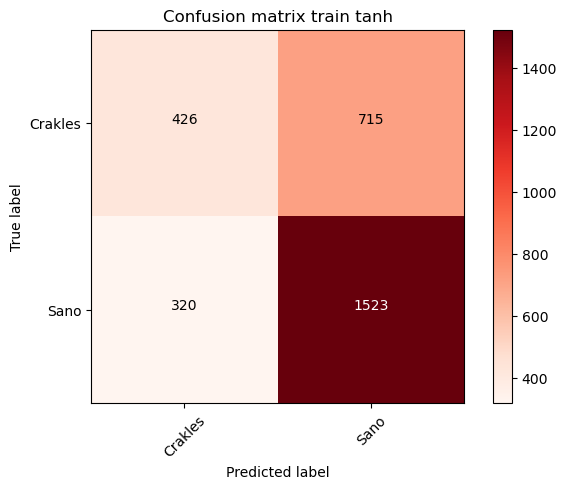

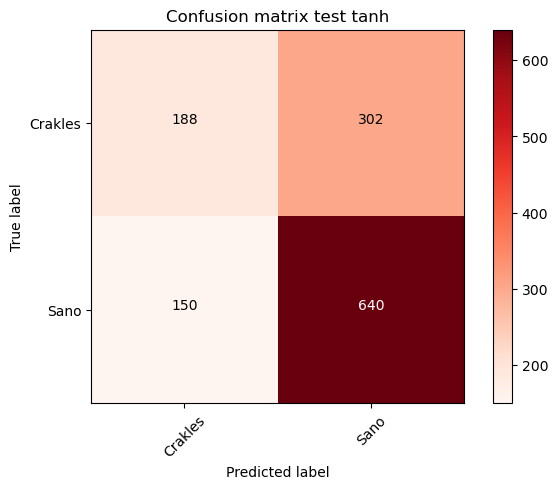

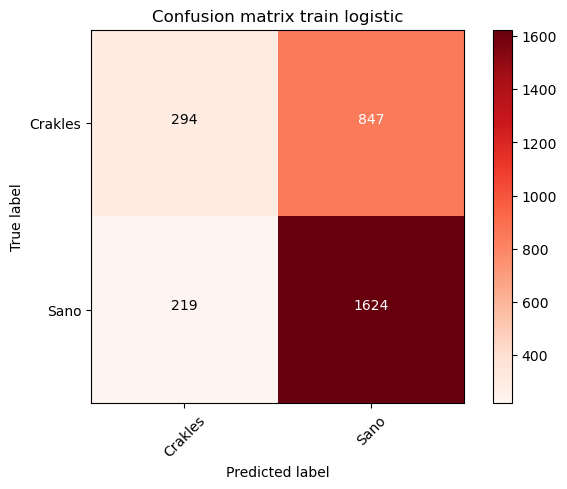

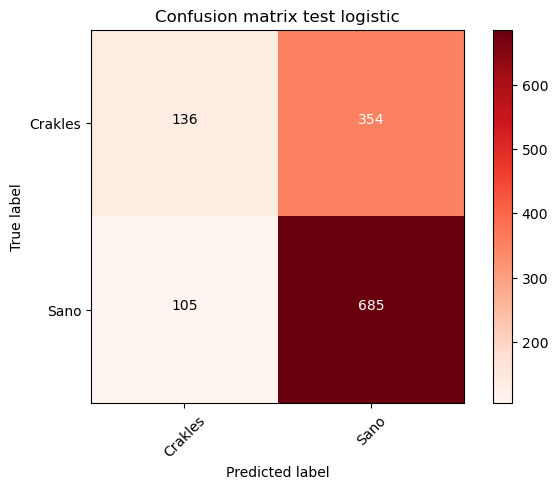

In [42]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Crakles','Sano'])

## Lo que no se pidió

In [43]:
#Se busca la mejor función de activación con los mejores macro parametros en este caso con la función de acurracy
it=list(tuple_generator1(1,20))
activation=['relu','identity','tanh','logistic']
param_grid = {'hidden_layer_sizes': it,"activation":activation}
mlp= MLPClassifier(solver='adam', max_iter=10000)
grid_search = GridSearchCV(mlp, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best_params["activation"], solver='adam', max_iter=10000) 
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.7s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(3, 3, 3); total time=   0.7s
[CV] END ......activation=relu, hidden_layer_si

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (18, 18, 18)}
Best Score: -0.6104103638922904
Train  relu
------------
              precision    recall  f1-score   support

           0       0.59      0.40      0.48      1141
           1       0.69      0.83      0.75      1843

    accuracy                           0.67      2984
   macro avg       0.64      0.62      0.62      2984
weighted avg       0.65      0.67      0.65      2984

Confusion matrix, without normalization
[[ 462  679]
 [ 317 1526]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.55      0.38      0.45       490
           1       0.68      0.81      0.74       790

    accuracy                           0.65      1280
   macro avg       0.62      0.60      0.60      1280
weighted avg       0.63      0.65      0.63      1280

Confusion matrix, without normalization
[[188 302]
 [151 639]]


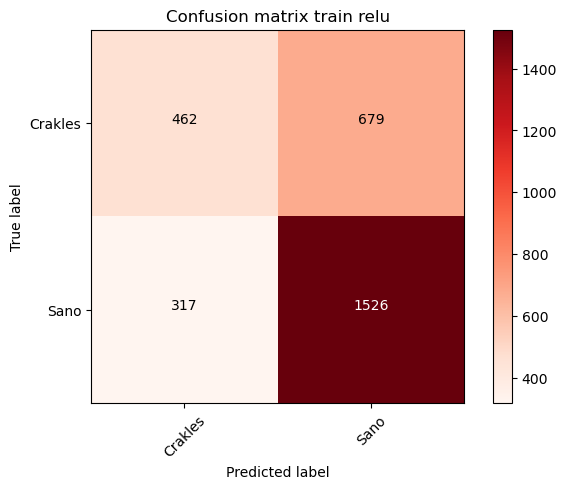

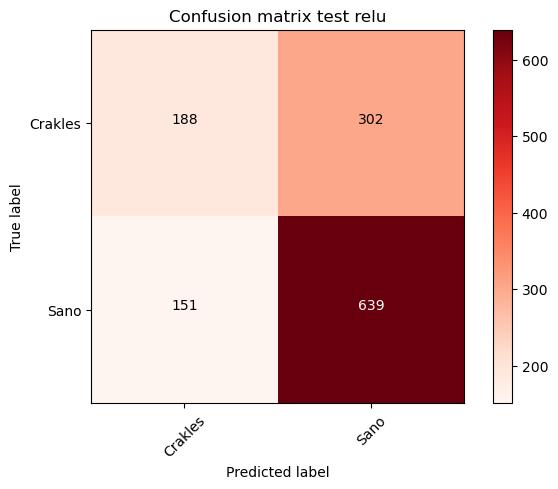

In [44]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Crakles','Sano'])

In [45]:
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................hidden_layer_sizes=(16, 16, 16); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(16, 16, 16); total time=   1.1s
[CV] END ....................hidden_layer_sizes=(16, 16, 16); total time=   1.2s
[CV] END ....................hidden_layer_sizes=(16, 16, 16); total time=   0.7s
[CV] END ....................hidden_layer_sizes=(16, 16, 16); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(16, 16, 17); total time=   1.1s
[CV] END ....................hidden_layer_sizes=(16, 16, 17); total time=   0.7s
[CV] END ....................hidden_layer_sizes=(16, 16, 17); total time=   1.2s
[CV] END ....................hidden_layer_sizes=(16, 16, 17); total time=   0.8s
[CV] END ....................hidden_layer_sizes=(16, 16, 17); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(16, 16, 18); total time=   0.7s
[CV] END ....................hidden_layer_sizes

Best Parameters: {'hidden_layer_sizes': (16, 16, 16)}
Best Score: -0.6107024998882704
Train  relu
------------
              precision    recall  f1-score   support

           0       0.58      0.39      0.47      1141
           1       0.69      0.82      0.75      1843

    accuracy                           0.66      2984
   macro avg       0.63      0.61      0.61      2984
weighted avg       0.65      0.66      0.64      2984

Confusion matrix, without normalization
[[ 450  691]
 [ 325 1518]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.56      0.39      0.46       490
           1       0.68      0.81      0.74       790

    accuracy                           0.65      1280
   macro avg       0.62      0.60      0.60      1280
weighted avg       0.63      0.65      0.63      1280

Confusion matrix, without normalization
[[192 298]
 [153 637]]


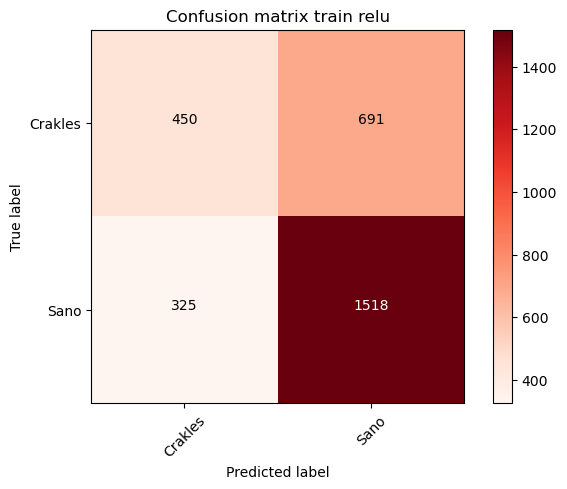

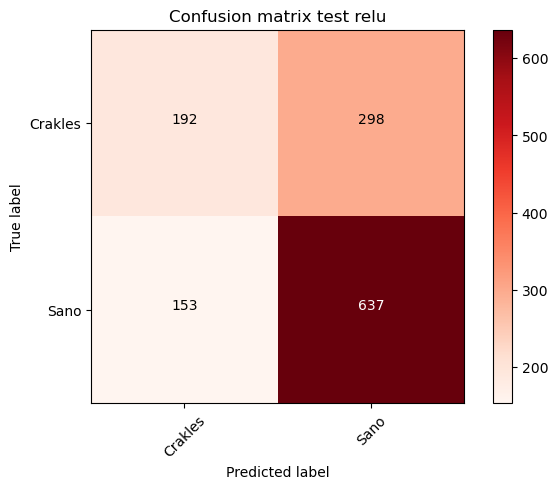

In [47]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles','Sano'])

# 2. Ciclos normales y ciclos silbantes

## Lo que pide el trabajo:

In [114]:
d=d2[d2["Estado"]==1].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d=pd.concat([d2[d2["Estado"]==2],d[:int(len(d2[d2["Estado"]==2])*1.5)]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
np.putmask(y,y == 2,0)
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)
scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)

print (Xtv.shape, Xts.shape)



(1637, 3) (1637,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(1145, 3) (492, 3)


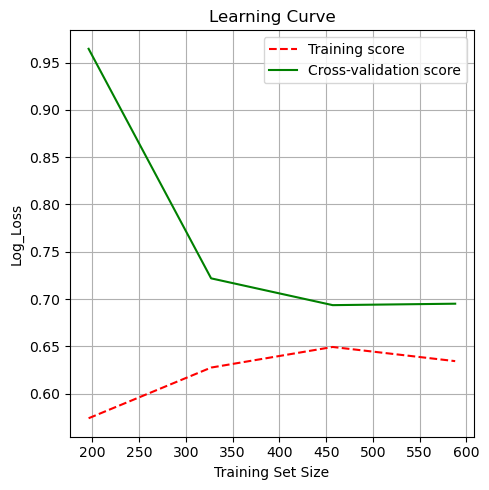

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [115]:
mlp= MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu',solver='adam', max_iter=10000)
lc_plot(mlp,Xtv,ytv)

Train  relu
------------
              precision    recall  f1-score   support

           0       0.74      0.56      0.64       459
           1       0.65      0.80      0.72       458

    accuracy                           0.68       917
   macro avg       0.69      0.68      0.68       917
weighted avg       0.69      0.68      0.68       917

Confusion matrix, without normalization
[[258 201]
 [ 91 367]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.67      0.55      0.61       196
           1       0.62      0.73      0.67       197

    accuracy                           0.64       393
   macro avg       0.65      0.64      0.64       393
weighted avg       0.65      0.64      0.64       393

Confusion matrix, without normalization
[[108  88]
 [ 53 144]]
Train  identity
------------
              precision    recall  f1-score   support

           0       0.71      0.33      0.45       459
           1       0.56      0.87

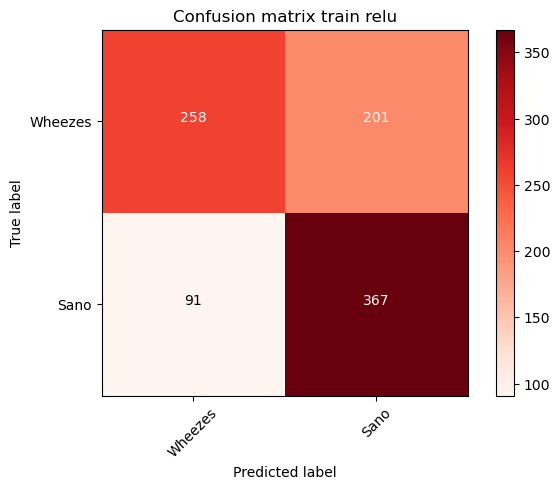

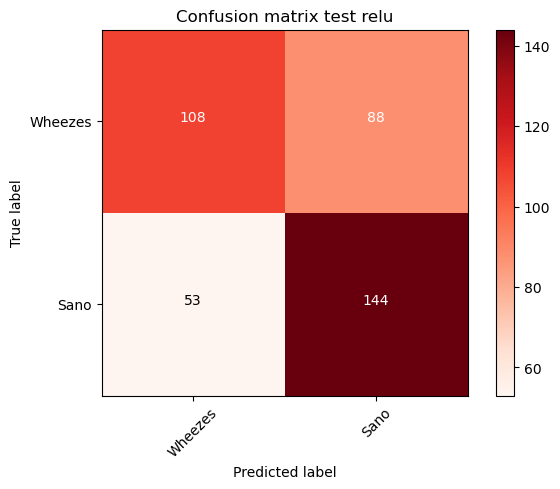

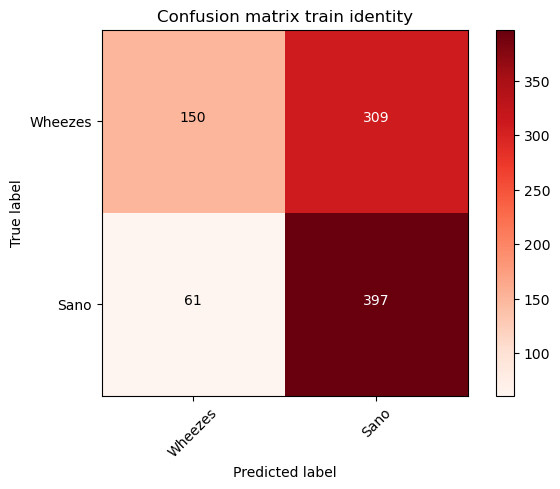

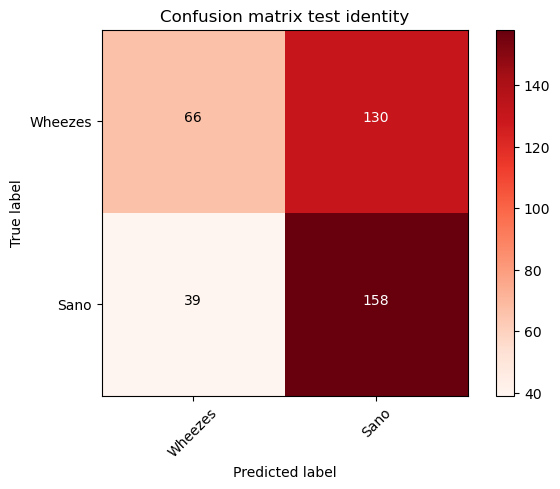

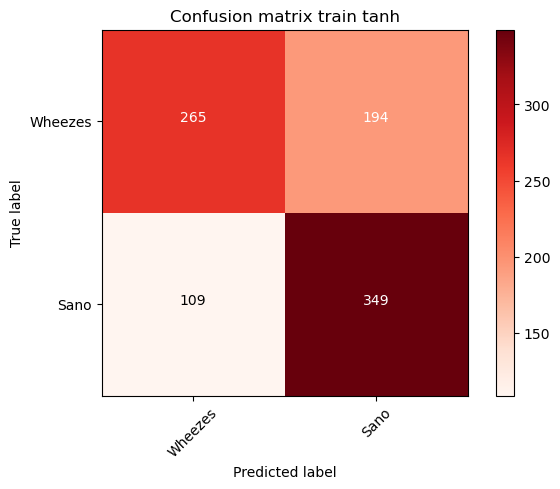

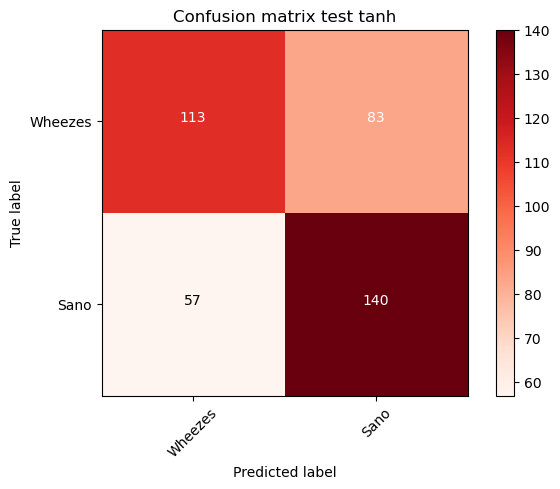

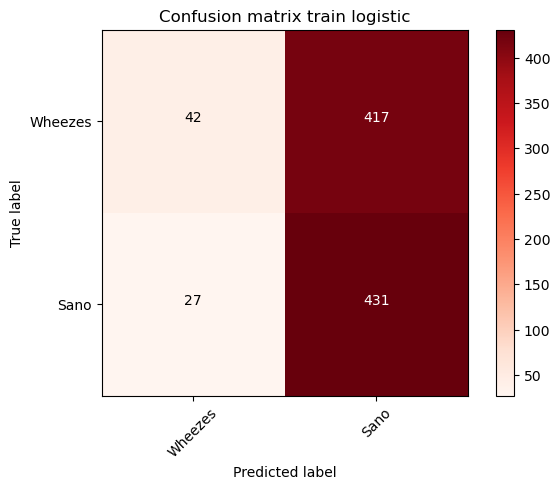

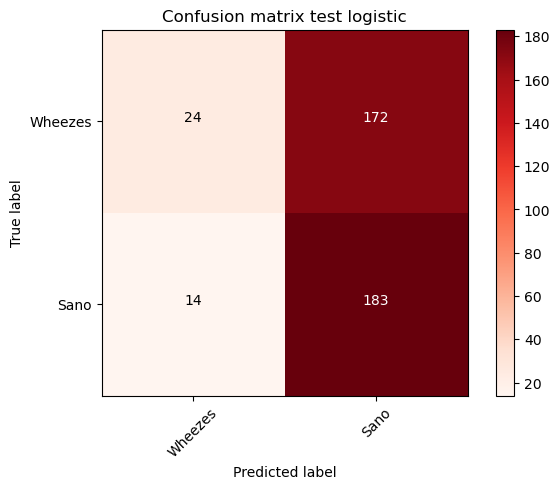

In [110]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Wheezes','Sano'])

## La optimización porque no voy a perder lo que estudie en IA

In [111]:
max_iter=list(500, 1000, 10000)
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
it=list(tuple_generator1(1,20))

activation=['relu','identity','tanh','logistic']
param_grid = {'hidden_layer_sizes': it,"activation":activation,"max_iter":max_iter}
mlp= MLPClassifier(solver='adam')
grid_search = GridSearchCV(mlp, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best_params["activation"], solver='adam', max_iter=best_params["max_iter"]) 


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.3s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.3s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(3, 3, 3); total time=   1.1s
[CV] END ......activation=relu, hidden_layer_si

Best Parameters: {'activation': 'identity', 'hidden_layer_sizes': (16, 16, 16)}
Best Score: 0.6788381556149102
Train  identity
------------
              precision    recall  f1-score   support

           1       0.54      0.89      0.67       459
           2       0.69      0.24      0.36       458

    accuracy                           0.57       917
   macro avg       0.62      0.57      0.52       917
weighted avg       0.62      0.57      0.52       917

Confusion matrix, without normalization
[[410  49]
 [348 110]]
------------
Test  identity
              precision    recall  f1-score   support

           1       0.55      0.89      0.68       196
           2       0.72      0.28      0.40       197

    accuracy                           0.59       393
   macro avg       0.64      0.59      0.54       393
weighted avg       0.64      0.59      0.54       393

Confusion matrix, without normalization
[[175  21]
 [142  55]]
MLPClassifier(activation='identity', hidden_layer_si

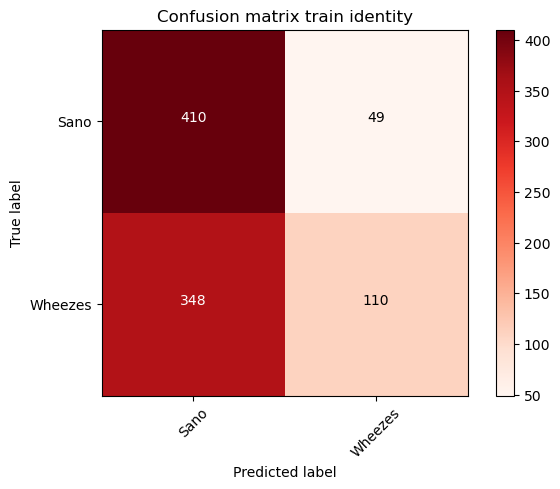

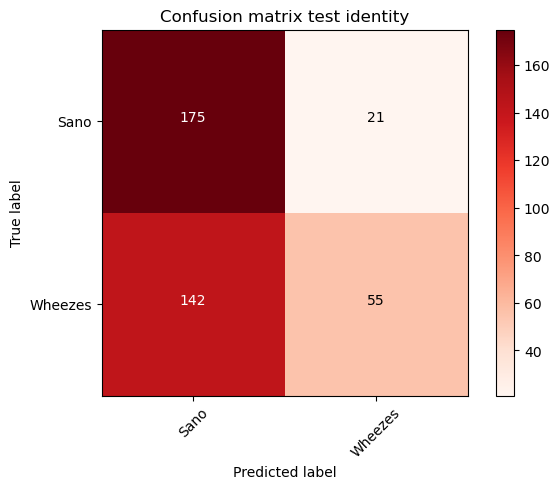

In [94]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Sano','Wheezes'])
print(best)

In [95]:
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 16); total time=   0.0s
[CV] END ....................hidden_layer_sizes

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (19, 19, 19)}
Best Score: -0.6648227780872034
Train  tanh
------------
              precision    recall  f1-score   support

           1       0.55      0.88      0.68       459
           2       0.70      0.29      0.41       458

    accuracy                           0.58       917
   macro avg       0.63      0.58      0.54       917
weighted avg       0.63      0.58      0.54       917

Confusion matrix, without normalization
[[402  57]
 [326 132]]
------------
Test  tanh
              precision    recall  f1-score   support

           1       0.56      0.87      0.68       196
           2       0.71      0.32      0.44       197

    accuracy                           0.59       393
   macro avg       0.63      0.59      0.56       393
weighted avg       0.63      0.59      0.56       393

Confusion matrix, without normalization
[[170  26]
 [134  63]]


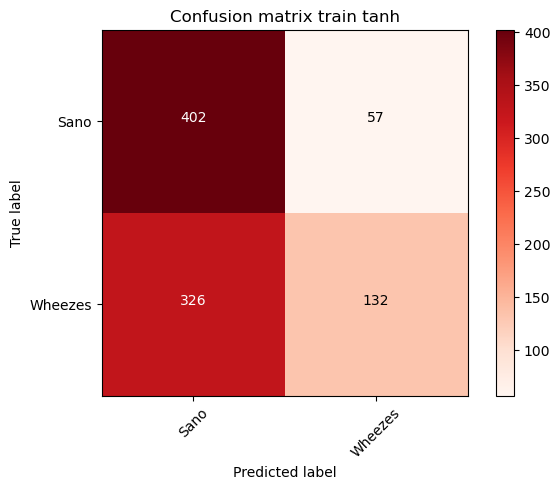

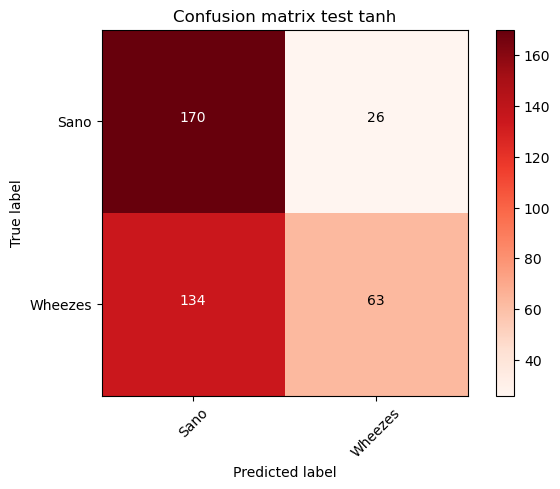

In [98]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Sano','Wheezes'])

## 3. Silibantes y crepitantes

## Lo que si 

In [137]:
d=d2[d2["Estado"]==0].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d=pd.concat([d2[d2["Estado"]==2],d[:int(len(d2[d2["Estado"]==2])*1.5)]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
np.putmask(y,y == 2,1)
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)

scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)
print (Xtv.shape, Xts.shape)

(1637, 3) (1637,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(1145, 3) (492, 3)


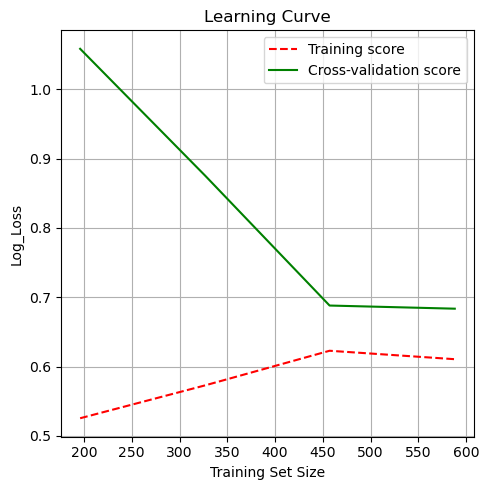

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [138]:
mlp= MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu',solver='adam', max_iter=10000)
lc_plot(mlp,Xtv,ytv)

Train  relu
------------
              precision    recall  f1-score   support

           0       0.67      0.84      0.74       687
           1       0.61      0.36      0.46       458

    accuracy                           0.65      1145
   macro avg       0.64      0.60      0.60      1145
weighted avg       0.64      0.65      0.63      1145

Confusion matrix, without normalization
[[579 108]
 [291 167]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.66      0.85      0.75       295
           1       0.61      0.35      0.44       197

    accuracy                           0.65       492
   macro avg       0.64      0.60      0.59       492
weighted avg       0.64      0.65      0.62       492

Confusion matrix, without normalization
[[252  43]
 [129  68]]
Train  identity
------------
              precision    recall  f1-score   support

           0       0.60      0.99      0.75       687
           1       0.57      0.03

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       687
           1       0.00      0.00      0.00       458

    accuracy                           0.60      1145
   macro avg       0.30      0.50      0.37      1145
weighted avg       0.36      0.60      0.45      1145

Confusion matrix, without normalization
[[687   0]
 [458   0]]
------------
Test  logistic
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       295
           1       0.00      0.00      0.00       197

    accuracy                           0.60       492
   macro avg       0.30      0.50      0.37       492
weighted avg       0.36      0.60      0.45       492

Confusion matrix, without normalization
[[295   0]
 [197   0]]


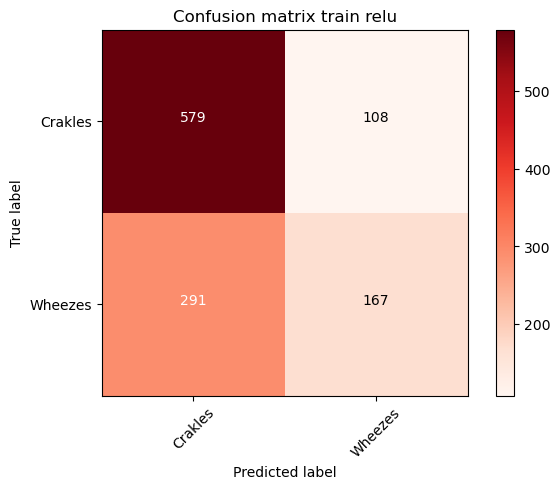

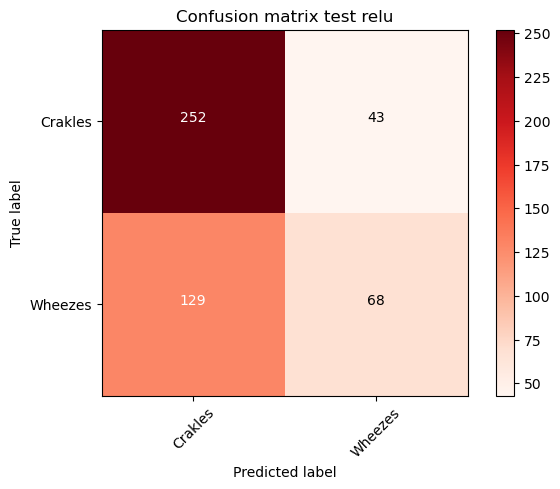

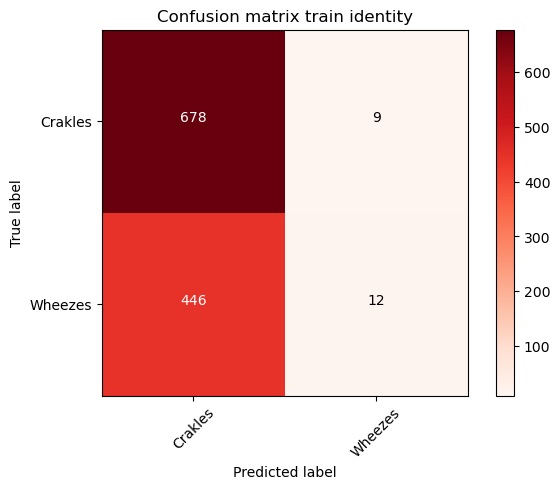

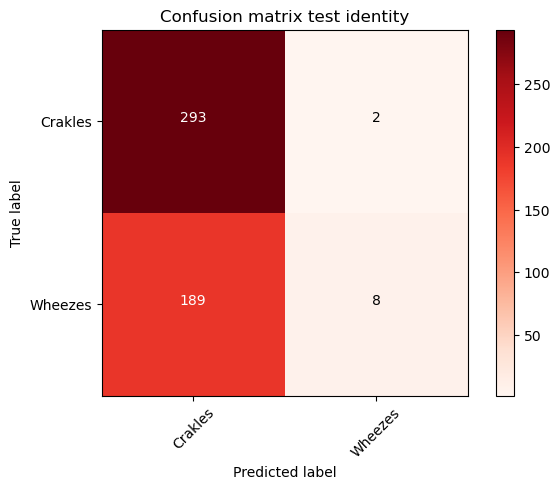

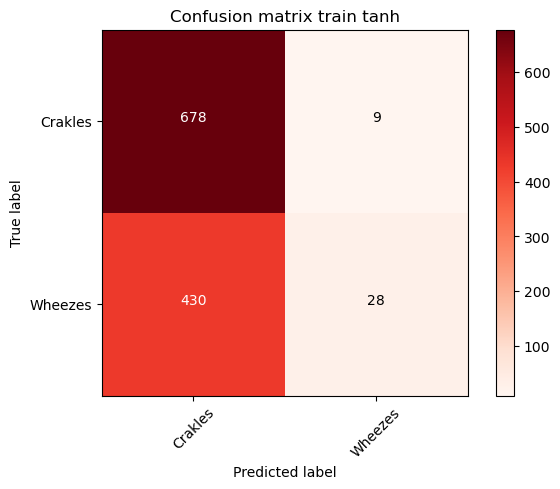

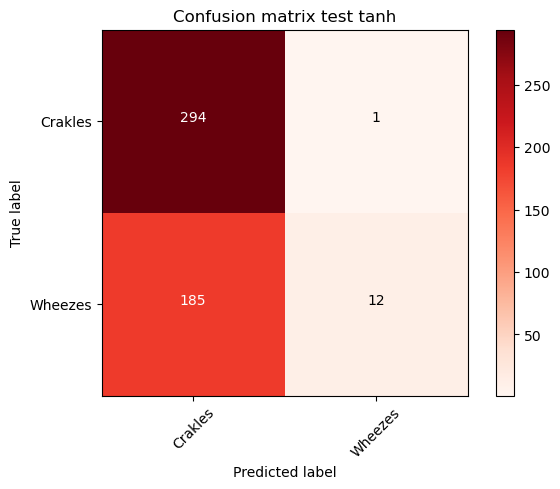

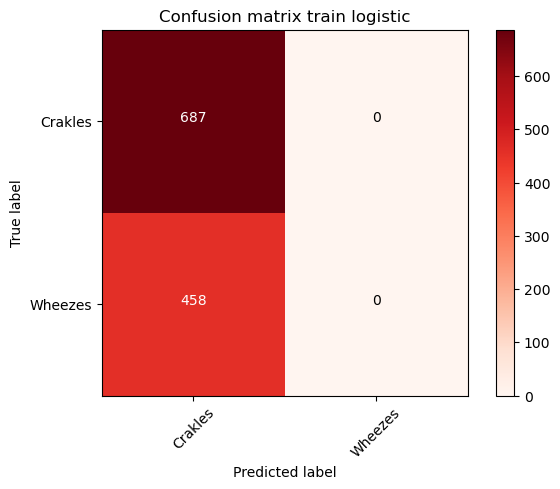

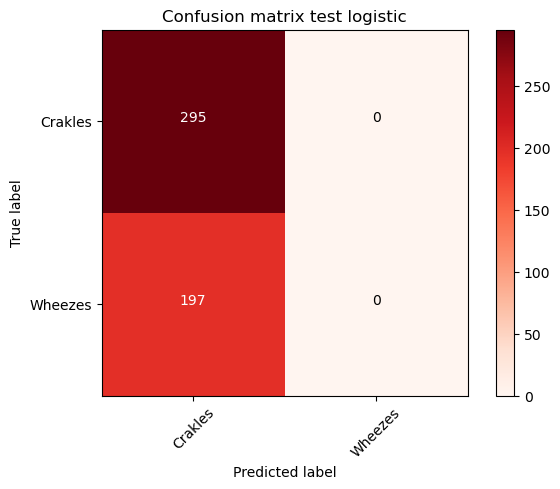

In [139]:

mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

## Lo que espero que nos den más nota:

In [140]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
it=list(tuple_generator1(1,20))
activation=['relu','identity','tanh','logistic']
param_grid = {'hidden_layer_sizes': it,"activation":activation}
mlp= MLPClassifier(solver='adam', max_iter=10000)
grid_search = GridSearchCV(mlp, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best_params["activation"], solver='adam', max_iter=10000) 

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.5s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.3s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.7s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.3s
[CV] END ......activation=relu, hidden_layer_sizes=(3, 3, 3); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_si

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (20, 20, 20)}
Best Score: -0.6580604329160773
Train  relu
------------
              precision    recall  f1-score   support

           0       0.64      0.88      0.74       687
           1       0.60      0.27      0.37       458

    accuracy                           0.64      1145
   macro avg       0.62      0.58      0.56      1145
weighted avg       0.63      0.64      0.60      1145

Confusion matrix, without normalization
[[606  81]
 [334 124]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.65      0.90      0.76       295
           1       0.65      0.27      0.39       197

    accuracy                           0.65       492
   macro avg       0.65      0.59      0.57       492
weighted avg       0.65      0.65      0.61       492

Confusion matrix, without normalization
[[266  29]
 [143  54]]
MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=10000)


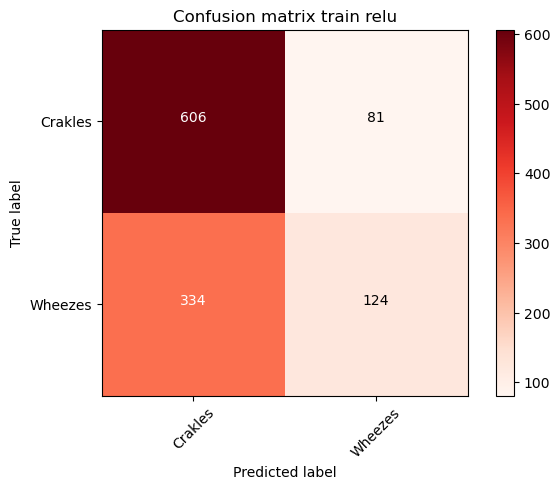

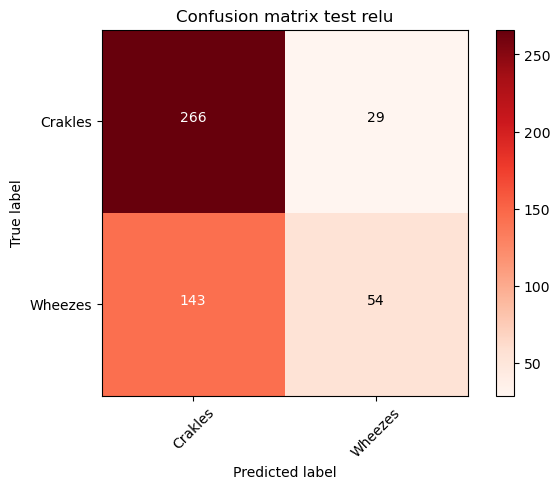

In [141]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])
print(best)

In [142]:
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   0.7s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   1.1s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   0.5s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.8s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.5s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.4s
[CV] END ....................hidden_layer_sizes=(18, 18, 20); total time=   0.8s
[CV] END ....................hidden_layer_sizes

Best Parameters: {'hidden_layer_sizes': (18, 19, 18)}
Best Score: -0.6594863927466432
Train  relu
------------
              precision    recall  f1-score   support

           0       0.66      0.85      0.75       687
           1       0.61      0.34      0.44       458

    accuracy                           0.65      1145
   macro avg       0.64      0.60      0.59      1145
weighted avg       0.64      0.65      0.62      1145

Confusion matrix, without normalization
[[587 100]
 [301 157]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       295
           1       0.69      0.37      0.48       197

    accuracy                           0.68       492
   macro avg       0.68      0.63      0.63       492
weighted avg       0.68      0.68      0.65       492

Confusion matrix, without normalization
[[262  33]
 [124  73]]


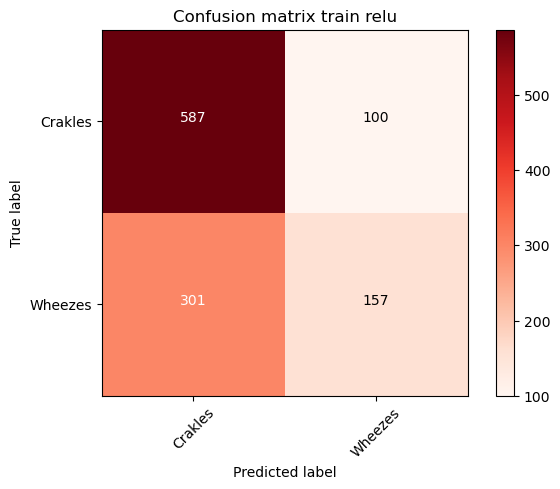

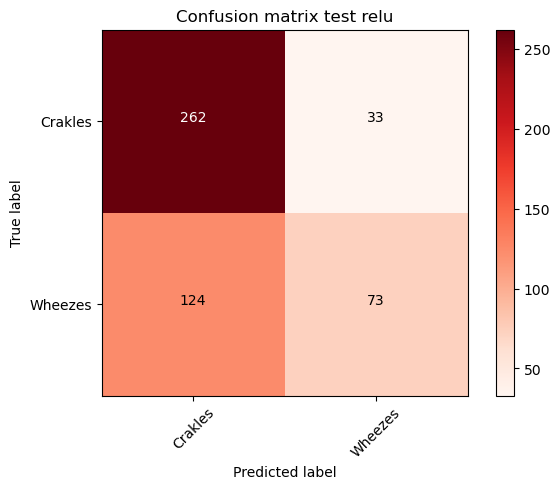

In [143]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

# 4. Normales, silibantes y crepitantes

## Franklin perdón si llegas hasta aquí

In [144]:
d=d2[d2["Estado"]==0].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d1=d2[d2["Estado"]==1].sample(frac=1, random_state=23)
d=pd.concat([d2[d2["Estado"]==2],d[:int(len(d2[d2["Estado"]==2])*1.5)],d1[:int(len(d2[d2["Estado"]==2])*1.5)] ])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)
scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)
print (Xtv.shape, Xts.shape)


(2619, 3) (2619,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(1833, 3) (786, 3)


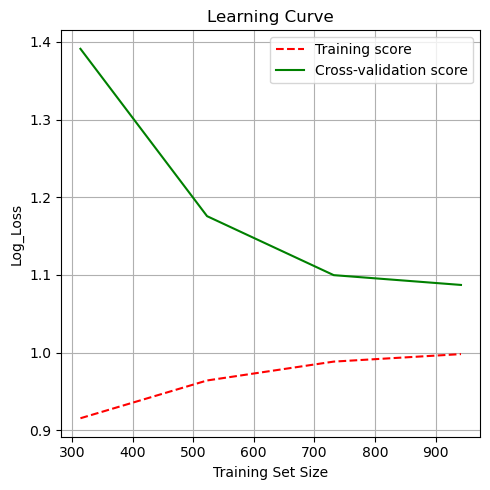

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [145]:
mlp= MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu',solver='adam', max_iter=10000)
lc_plot(mlp,Xtv,ytv)

Train  relu
------------
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       687
           1       0.47      0.67      0.55       687
           2       0.51      0.05      0.09       459

    accuracy                           0.49      1833
   macro avg       0.50      0.44      0.40      1833
weighted avg       0.50      0.49      0.44      1833

Confusion matrix, without normalization
[[411 268   8]
 [211 462  14]
 [188 248  23]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.52      0.59      0.55       295
           1       0.48      0.71      0.57       295
           2       0.21      0.02      0.03       196

    accuracy                           0.49       786
   macro avg       0.40      0.44      0.38       786
weighted avg       0.43      0.49      0.43       786

Confusion matrix, without normalization
[[174 117   4]
 [ 80 208   7]
 [ 81 112   3]]
Train  identity
-

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

              precision    recall  f1-score   support

           0       0.37      1.00      0.55       687
           1       0.00      0.00      0.00       687
           2       0.00      0.00      0.00       459

    accuracy                           0.37      1833
   macro avg       0.12      0.33      0.18      1833
weighted avg       0.14      0.37      0.20      1833

Confusion matrix, without normalization
[[687   0   0]
 [687   0   0]
 [459   0   0]]
------------
Test  logistic
              precision    recall  f1-score   support

           0       0.38      1.00      0.55       295
           1       0.00      0.00      0.00       295
           2       0.00      0.00      0.00       196

    accuracy                           0.38       786
   macro avg       0.13      0.33      0.18       786
weighted avg       0.14      0.38      0.20       786

Confusion matrix, without normalization
[[295   0   0]
 [295   0   0]
 [196   0   0]]


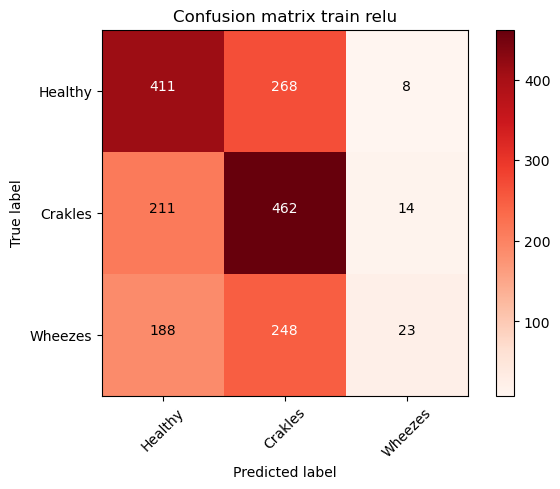

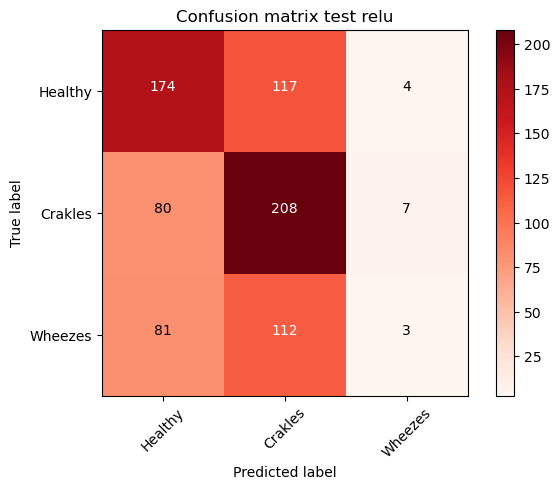

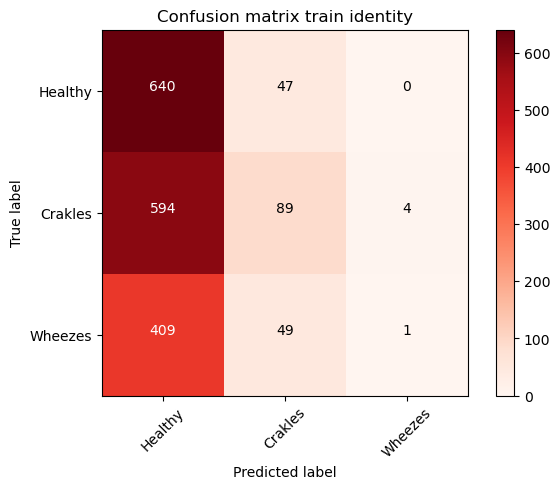

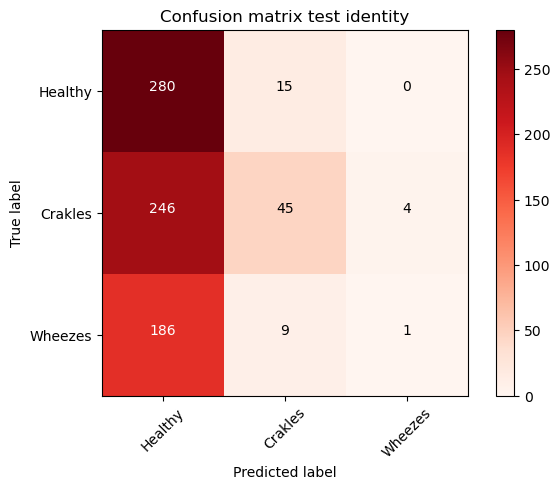

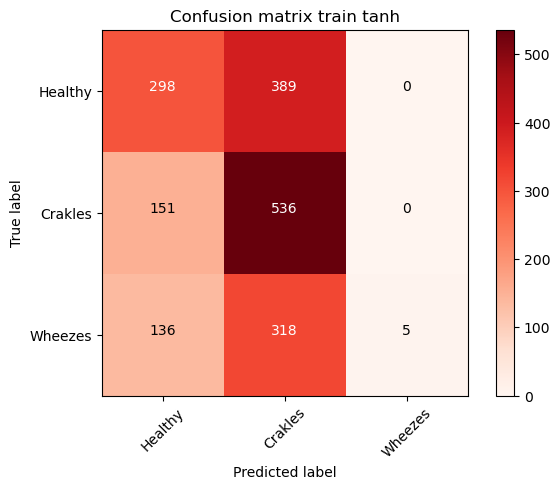

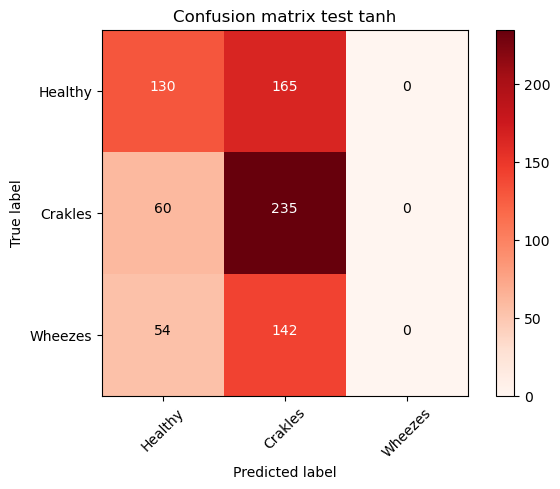

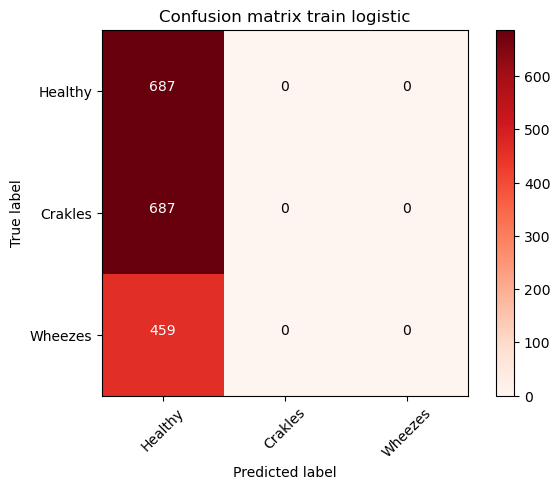

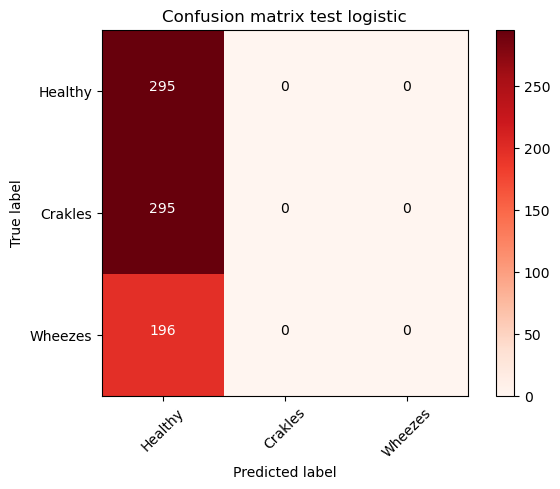

In [146]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])

## Dormir esta sobrevalorado 

In [147]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
it=list(tuple_generator1(1,20))
activation=['relu','identity','tanh','logistic']
param_grid = {'hidden_layer_sizes': it,"activation":activation}
mlp= MLPClassifier(solver='adam', max_iter=10000)
grid_search = GridSearchCV(mlp, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best_params["activation"], solver='adam', max_iter=10000) 

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.3s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.3s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(3, 3, 3); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_si

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10)}
Best Score: -1.053953195313205
Train  relu
------------
              precision    recall  f1-score   support

           0       0.49      0.66      0.56       687
           1       0.49      0.63      0.55       687
           2       0.86      0.01      0.03       459

    accuracy                           0.49      1833
   macro avg       0.61      0.43      0.38      1833
weighted avg       0.58      0.49      0.42      1833

Confusion matrix, without normalization
[[454 233   0]
 [254 432   1]
 [228 225   6]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.52      0.70      0.60       295
           1       0.51      0.67      0.58       295
           2       1.00      0.01      0.01       196

    accuracy                           0.52       786
   macro avg       0.68      0.46      0.40       786
weighted avg       0.64      0.52      0.44       7

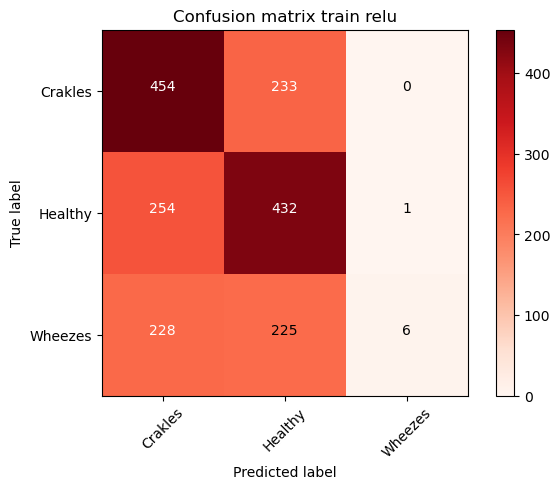

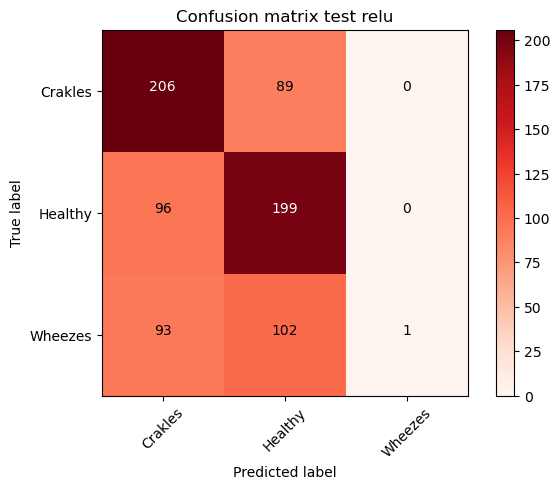

In [148]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Crakles',"Healthy",'Wheezes'])

In [149]:
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .......................hidden_layer_sizes=(8, 8, 8); total time=   1.6s
[CV] END .......................hidden_layer_sizes=(8, 8, 8); total time=   0.7s
[CV] END .......................hidden_layer_sizes=(8, 8, 8); total time=   0.5s
[CV] END .......................hidden_layer_sizes=(8, 8, 8); total time=   0.5s
[CV] END .......................hidden_layer_sizes=(8, 8, 8); total time=   0.8s
[CV] END .......................hidden_layer_sizes=(8, 8, 9); total time=   1.1s
[CV] END .......................hidden_layer_sizes=(8, 8, 9); total time=   0.8s
[CV] END .......................hidden_layer_sizes=(8, 8, 9); total time=   0.8s
[CV] END .......................hidden_layer_sizes=(8, 8, 9); total time=   1.0s
[CV] END .......................hidden_layer_sizes=(8, 8, 9); total time=   0.6s
[CV] END ......................hidden_layer_sizes=(8, 8, 10); total time=   1.0s
[CV] END ......................hidden_layer_siz

Best Parameters: {'hidden_layer_sizes': (8, 8, 9)}
Best Score: -1.0553106361934115
Train  relu
------------
              precision    recall  f1-score   support

           0       0.50      0.59      0.54       687
           1       0.47      0.68      0.55       687
           2       0.75      0.02      0.04       459

    accuracy                           0.48      1833
   macro avg       0.57      0.43      0.38      1833
weighted avg       0.55      0.48      0.42      1833

Confusion matrix, without normalization
[[405 282   0]
 [216 468   3]
 [194 256   9]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.51      0.59      0.55       295
           1       0.47      0.71      0.56       295
           2       1.00      0.01      0.01       196

    accuracy                           0.49       786
   macro avg       0.66      0.43      0.37       786
weighted avg       0.62      0.49      0.42       786

Confusion matrix, wi

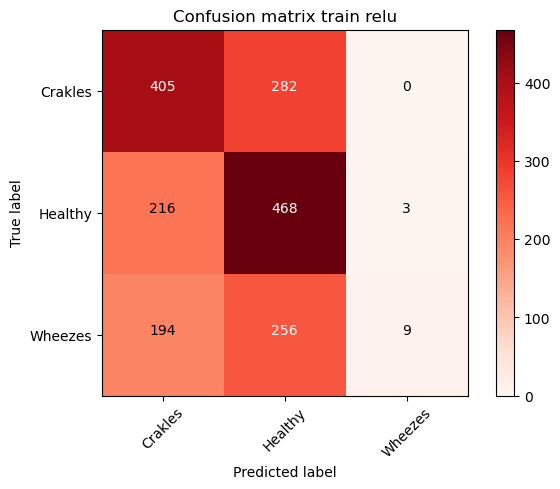

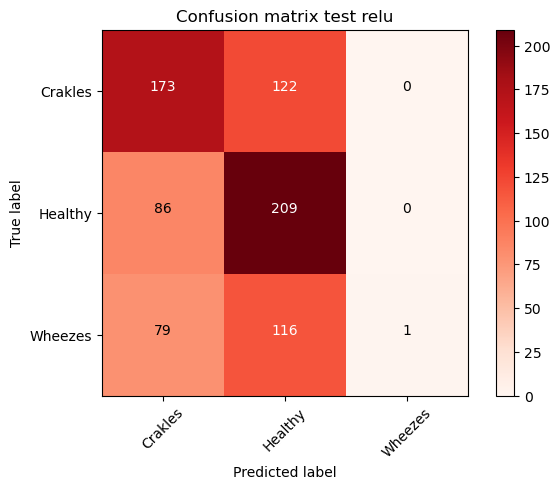

In [150]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles',"Healthy",'Wheezes'])

## K means

In [203]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from mpl_toolkits.mplot3d import Axes3D

In [255]:
def plot_clusters(X,y):
    n_clusters = len(np.unique(y))
    cmap = plt.cm.bwr if n_clusters==2 else plt.cm.plasma
    cmap((y*255./(n_clusters-1)).astype(int))
    for i in np.unique(y):
        col = cmap((i*255./(n_clusters-1)).astype(int))
        Xr = X[y==i]
        plt.scatter(Xr[:,0], Xr[:,1], color=col, label="cluster %d"%i, alpha=.5)
    plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],marker="x", lw=5, s=200, color="black")
    plt.legend()    
    plt.xlabel("Varianza normalizada")
    plt.ylabel("Mediana normalizada");

In [256]:
def plot_clusters3D(X, y,plotcenter=False):
    name=["Crackles","Healthy","Silibantes"]
    n_clusters = len(np.unique(y))
    cmap = plt.cm.bwr if n_clusters == 2 else plt.cm.plasma
    cmap((y * 255. / (n_clusters - 1)).astype(int))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for i in np.unique(y):
        col = cmap((i * 255. / (n_clusters - 1)).astype(int))
        Xr = X[y == i]
        ax.scatter(Xr[:, 0], Xr[:, 1], Xr[:, 2], color=col, label=name[i], alpha=.5)
    if plotcenter:
        ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], km.cluster_centers_[:, 2],
                marker="x", lw=5, s=200, color="black")
    
    ax.legend(loc="best")
    ax.set_zlabel("Varianza normalizada")
    ax.set_ylabel("Mediana normalizada")
    ax.set_xlabel("Sumatoria normalizada")
    
    plt.show()

In [257]:
def plot_clusters_2d(X, y, centers,plotcenter=False):
    n_clusters = len(np.unique(y))
    cmap = plt.cm.bwr if n_clusters == 2 else plt.cm.plasma
    cmap((y * 255. / (n_clusters - 1)).astype(int))
    name=["Crackles","Healthy","Silibantes"]
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_xlabel("Sumatoria normalizada")
    axs[0].set_ylabel("Mediana normalizada")
    axs[1].set_xlabel("Sumatoria normalizada")
    axs[1].set_ylabel("Varianza normalizada")
    axs[2].set_xlabel("Mediana normalizada")
    axs[2].set_ylabel("Varianza normalizada")

    for i in np.unique(y):
        col = cmap((i * 255. / (n_clusters - 1)).astype(int))
        Xr = X[y == i]
        axs[0].scatter(Xr[:, 0], Xr[:, 1], color=col, label=name[i], alpha=.5)
        axs[1].scatter(Xr[:, 0], Xr[:, 2], color=col, label=name[i], alpha=.5)
        axs[2].scatter(Xr[:, 1], Xr[:, 2], color=col, label=name[i], alpha=.5)
    if plotcenter:
        axs[0].scatter(centers[:, 0], centers[:, 1], marker="x", color="black", label="Cluster Centers")
        axs[1].scatter(centers[:, 0], centers[:, 2], marker="x", color="black", label="Cluster Centers")
        axs[2].scatter(centers[:, 1], centers[:, 2], marker="x", color="black", label="Cluster Centers")

    axs[0].legend(loc="best")
    axs[1].legend(loc="best")
    axs[2].legend(loc="best")
    
    plt.tight_layout()
    plt.show()

In [281]:
d=d2[d2["Estado"]==0].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d1=d2[d2["Estado"]==1].sample(frac=1, random_state=23)
d=pd.concat([d2[d2["Estado"]==2],d[:int(len(d2[d2["Estado"]==2])*1.5)],d1[:int(len(d2[d2["Estado"]==2])*1.5)] ])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
scaler=StandardScaler()
scaler.fit(x)
x_kms=scaler.transform(x)

In [282]:
km = KMeans(n_clusters=3, random_state=23, n_init="auto")
km.fit(x_kms)
y_kms=km.predict(x_kms)

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


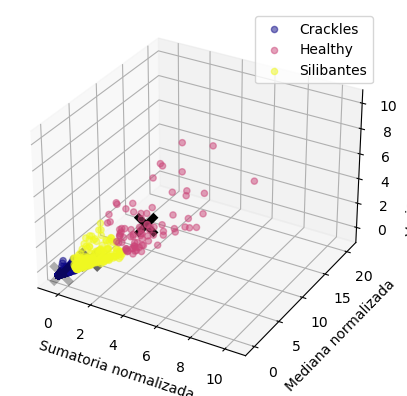

In [287]:
plot_clusters3D(x_kms,y_kms,plotcenter=True)

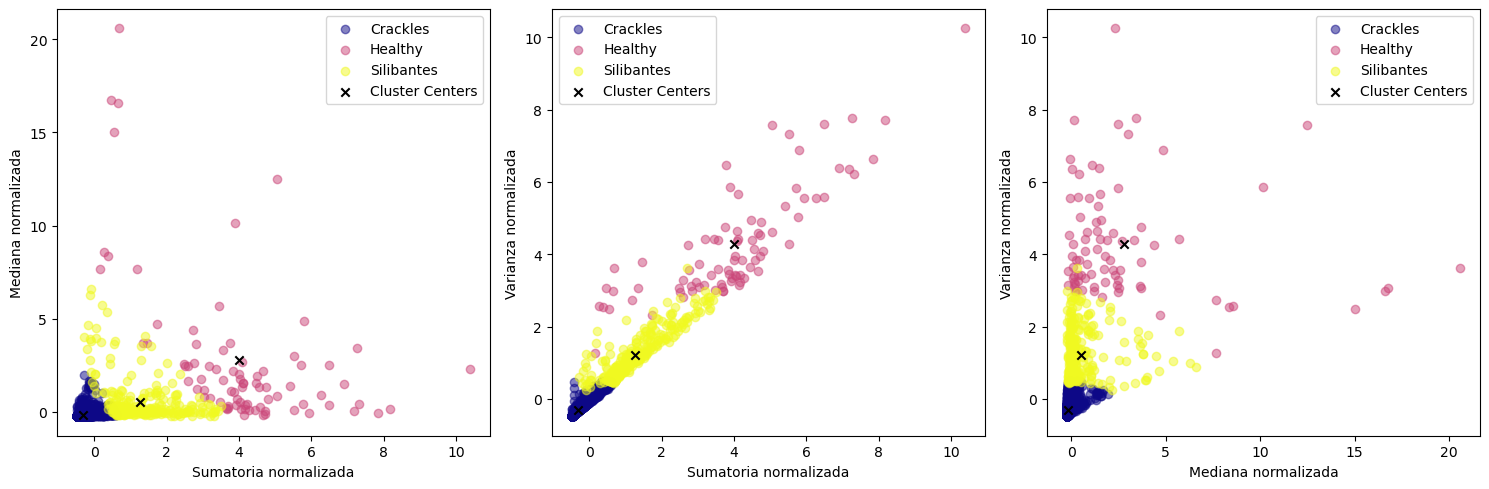

In [288]:
centers_kms = km.cluster_centers_
plot_clusters_2d(x_kms,y_kms,centers_kms,True)

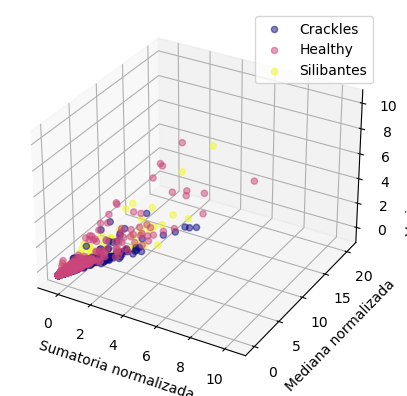

In [289]:
plot_clusters3D(x_kms,y)

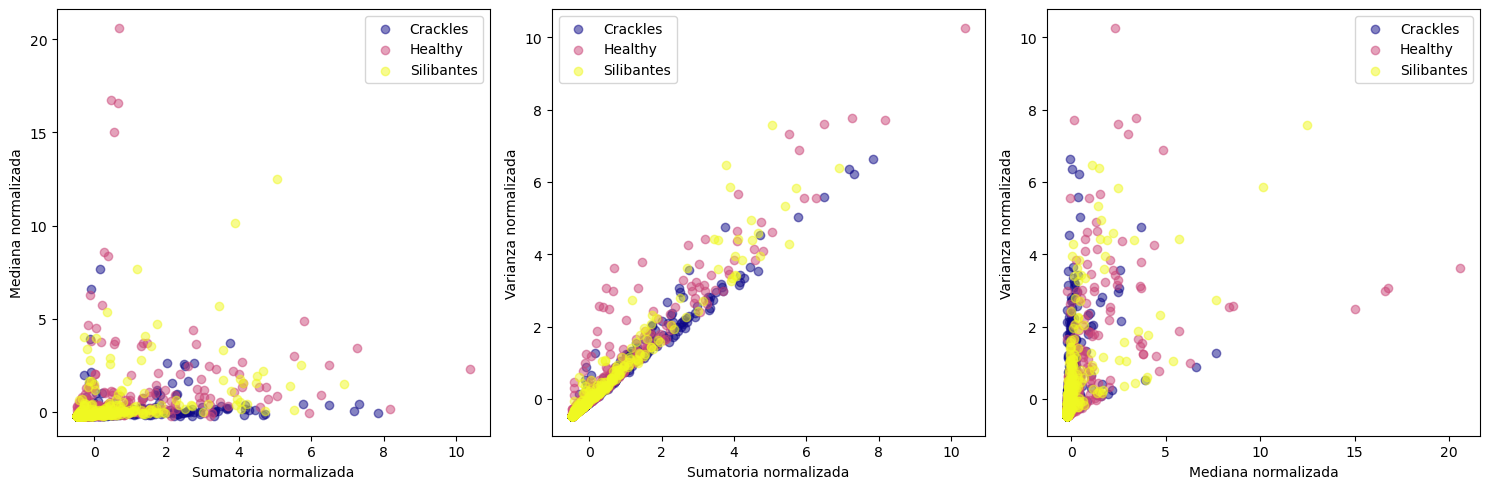

In [290]:
plot_clusters_2d(x_kms,y,centers_kms,False)

In [320]:
kmeans.inertia_

2718.9898983998255

In [324]:
silhouette_score(x_kms,km.labels_)

0.7529779668327895

In [323]:
adjusted_rand_score(y,km.labels_)

0.000547592803148906

## Kmeans para crepitantes y sanos

En este caso al ser un ejemplo de 3 dimensiones es complicado ver como se hace un cluster o como se ve un centroide, para ello entonces tomaremos un ejemplo dado anteriormente. Así los datos mostrados anteriormente representarían una esfera 3d que encierra los parámetros. En este caso para efectos prácticos eliminaremos la columna de sumatoria la cual presenta menor coherencia con los datos

In [264]:
d=pd.concat([d2[d2["Estado"]==0],d2[d2["Estado"]==1]])
x=d.drop(["Estado","Sumatoria"],axis=1)
y=d.Estado.values
scaler=StandardScaler()
scaler.fit(x)
x_kms=scaler.transform(x)

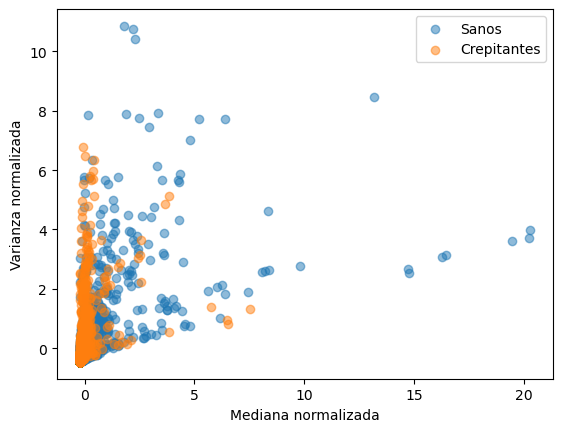

In [266]:
plt.scatter(x_kms[:,0][y==1], x_kms[:,1][y==1],label="Sanos",alpha=.5)
plt.scatter(x_kms[:,0][y==0], x_kms[:,1][y==0],label="Crepitantes",alpha=.5)
plt.xlabel("Mediana normalizada")
plt.ylabel("Varianza normalizada")
plt.legend()

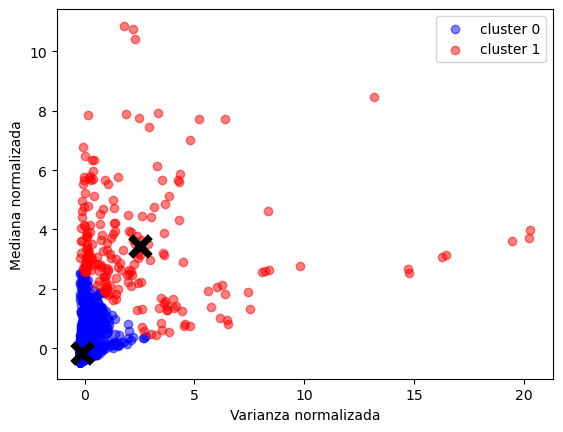

In [268]:
n_clusters = 2
km = KMeans(n_clusters=n_clusters,n_init="auto",random_state=23)
km.fit(x_kms)
y_kms = km.predict(x_kms)
plot_clusters(x_kms,y_kms)

In [41]:
#crackles y sano

d=pd.concat([d2[d2["Estado"]==0],d2[d2["Estado"]==1]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)
scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)
print (Xtv.shape, Xts.shape)

(4264, 3) (4264,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2984, 3) (1280, 3)


Train 
------------
              precision    recall  f1-score   support

           0       0.58      0.24      0.34      1141
           1       0.66      0.89      0.75      1843

    accuracy                           0.64      2984
   macro avg       0.62      0.57      0.55      2984
weighted avg       0.63      0.64      0.60      2984

Confusion matrix, without normalization
[[ 279  862]
 [ 205 1638]]
------------
Test 
              precision    recall  f1-score   support

           0       0.53      0.25      0.34       490
           1       0.65      0.86      0.74       790

    accuracy                           0.63      1280
   macro avg       0.59      0.56      0.54      1280
weighted avg       0.61      0.63      0.59      1280

Confusion matrix, without normalization
[[124 366]
 [109 681]]


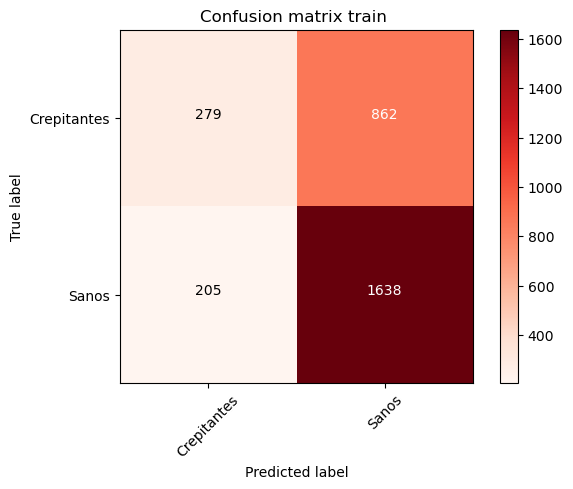

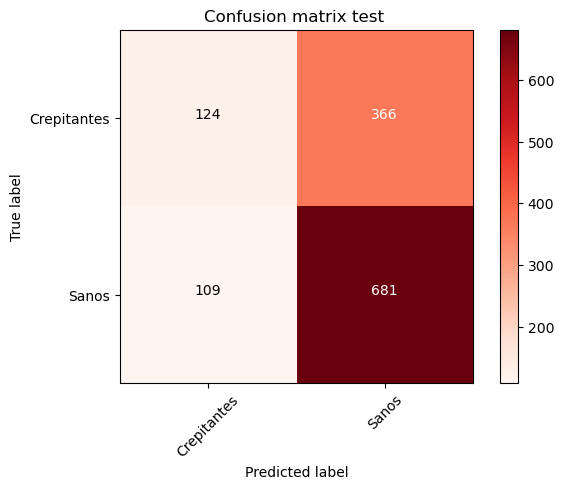

In [45]:
# crea un svm con los datos de entrenamiento
#importa lo necesario
from sklearn import svm
#crea el clasificador
target_names = ['Crepitantes', 'Sanos']
clf = svm.SVC()
clf.fit(Xtv, ytv)
#predice los datos de test
predict_test = clf.predict(Xts)
predict_train = clf.predict(Xtv)
#muestra los resultados
print("Train ")
print("------------")
print(classification_report(ytv,predict_train))
mc_train = confusion_matrix(ytv,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train ')
print("------------")
print("Test ")
print(classification_report(yts,predict_test))
mc_train = confusion_matrix(yts,predict_test)
plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix test ')

